In [18]:
import os, time, re
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nabstab.utils import load_model, test_model, AA2INDEX
from nabstab.datasets.classifier_dataset import pad_cdr2, NbStabilityDataset

In [10]:
## Get the paths setup
if '__file__' in globals():
    current_dir = Path(__file__).resolve().parent
else:
    current_dir = Path.cwd()

data_dir = current_dir.parent / 'data'
checkpoints_dir = current_dir.parent / 'model_checkpoints'

In [11]:
test_set = data_dir / 'model_training_data/ENN_test.csv'
test_df = pd.read_csv(test_set)
test_df_equal = pd.concat([test_df[test_df.stability == 'high'].sample(50000), test_df[test_df.stability == 'low'].sample(50000)])

In [4]:
lr_checkpoint = checkpoints_dir / 'LR/20231223_LR.pt'
lr_cdr12_checkpoint = checkpoints_dir / 'LR/cdr12.pt'
cnn_checkpoint = checkpoints_dir / 'CNN/cnn_24_fc_8.pt'
rnn_checkpoint = checkpoints_dir / 'RNN/20231223_64d_50epochs.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#load models
lrmodel = load_model(
    checkpoint_path=lr_checkpoint,
    model_type='lr',
    device=device
)

lrmodel_cdr12 = load_model(
    checkpoint_path=lr_cdr12_checkpoint,
    model_type='lr',
    sequence_length = 20,
    device=device
)

cnnmodel = load_model(
    checkpoint_path=cnn_checkpoint,
    model_type='cnn',
    device=device
)

rnnmodel = load_model(
    checkpoint_path=rnn_checkpoint,
    model_type='rnn',
    device=device
)

In [16]:
roc_auc_lr, fpr_lr, tpr_lr = test_model(lrmodel, test_df_equal, device)
roc_auc_cnn, fpr_cnn, tpr_cnn = test_model(cnnmodel, test_df_equal, device)
roc_auc_rnn, fpr_rnn, tpr_rnn = test_model(rnnmodel, test_df_equal, device)

In [17]:
#check the performance of the cdr1 and 2 model:
test_df['cdr2_padded'] = test_df['CDR2'].apply(pad_cdr2)
test_df['padded_sequence'] = test_df['CDR1'] + test_df['cdr2_padded']
sequences = list(test_df['padded_sequence'].values)
numseqs = torch.vstack([torch.tensor([AA2INDEX[aa] for aa in seq], dtype=torch.long) for seq in sequences])
preds = []
lrmodel_cdr12.eval()

batch_size = 256
for i in range(0, numseqs.shape[0], batch_size):
    batch = numseqs[i:i+batch_size].to(device)
    with torch.no_grad():
        preds.append(lrmodel_cdr12.predict(batch, return_logits=True))
all_preds = np.vstack(preds)

In [18]:
labels = np.array(test_df['stability'] == 'high', dtype=int)
roc_auc_lr_cdr12 = roc_auc_score(labels, all_preds)
fpr_lr_cdr12, tpr_lr_cdr12, _ = roc_curve(labels, all_preds)

We also evaluated TANGO on this dataset. [TANGO](https://www.nature.com/articles/nbt1012), which predicts the aggregation propensity of sequence segments.

This can by done by using the following command:
```bash
python scripts/run_tango.py --input_file path/to/file --output_dir /path/to/output_dir 
```

To run as-is, one must provide a dataframe with the following columns:
- `CDR1`
- `CDR2`
- `CDR3`

In [9]:
tango_df_file = data_dir / 'tango_output' / 'tango_results.csv'
tango_df = pd.read_csv(tango_df_file)

In [19]:
#total_agg_score is the best score. It's inversely correlated (high score here is more prone to aggregation)

labels_tango = np.array(tango_df['stability'] == 'high', dtype=int)
roc_auc_tango = roc_auc_score(labels_tango, -tango_df['total_agg_score'])
fpr_tango, tpr_tango, _ = roc_curve(labels_tango, -tango_df['total_agg_score'])

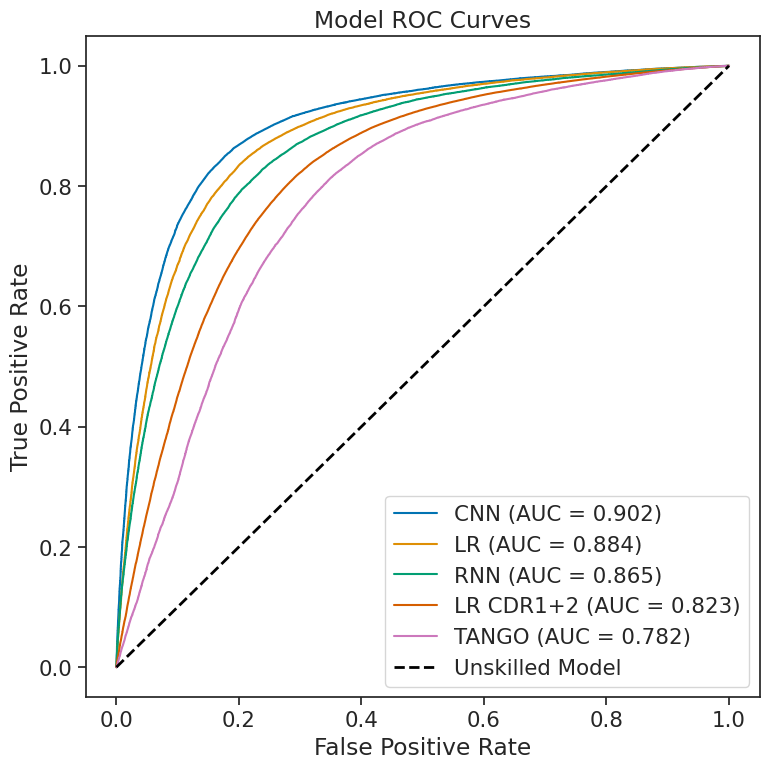

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

sns.set_theme(style='white', palette='colorblind', font_scale=1.4)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.minor.left'] = True

axs.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {roc_auc_cnn:.3f})')
axs.plot(fpr_lr, tpr_lr, label=f'LR (AUC = {roc_auc_lr:.3f})')
axs.plot(fpr_rnn, tpr_rnn, label=f'RNN (AUC = {roc_auc_rnn:.3f})')
axs.plot(fpr_lr_cdr12, tpr_lr_cdr12, label=f'LR CDR1+2 (AUC = {roc_auc_lr_cdr12:.3f})')
axs.plot(fpr_tango, tpr_tango, label=f'TANGO (AUC = {roc_auc_tango:.3f})')

axs.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Unskilled Model')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.set_title('Model ROC Curves')
axs.legend()

axs.spines['left'].set_visible(True)
axs.spines['bottom'].set_visible(True)

plt.tight_layout()
plt.savefig(current_dir/ 'figure_3_outputs'/ 'roc_curve.pdf')

In [22]:
#save the curves as a csv, every 20th point
for condition in ['cnn', 'lr', 'rnn', 'lr_cdr12', 'tango']:
    fpr = eval(f'fpr_{condition}')
    tpr = eval(f'tpr_{condition}')
    with open(current_dir / 'figure_3_outputs' / f'{condition}_roc_curve.csv', 'w') as f:
        f.write('fpr,tpr\n')
        for i in range(0, len(fpr), 40):
            f.write(f'{fpr[i]},{tpr[i]}\n')


General statistics of the models - how well do they separate the two classes?

In [8]:
test_numseqs = torch.vstack([torch.tensor([AA2INDEX.get(aa, 20) for aa in seq], dtype=torch.long) for seq in test_df_equal.seq.values])
test_preds_lr = []
test_preds_cnn = []
test_preds_rnn = []
for i in np.arange(0, test_numseqs.shape[0], 1024):
    batch = test_numseqs[i:i+1024].to(device)
    with torch.no_grad():
        test_preds_lr.append(lrmodel.predict(batch, return_logits=True))
        test_preds_cnn.append(cnnmodel.predict(batch, return_logits=True))
        test_preds_rnn.append(rnnmodel.predict(batch, return_logits=True))

test_preds_lr = np.vstack(test_preds_lr)
test_preds_cnn = np.vstack(test_preds_cnn)
test_preds_rnn = np.vstack(test_preds_rnn)

test_df_equal['lr_pred'] = test_preds_lr
test_df_equal['cnn_pred'] = test_preds_cnn
test_df_equal['rnn_pred'] = test_preds_rnn

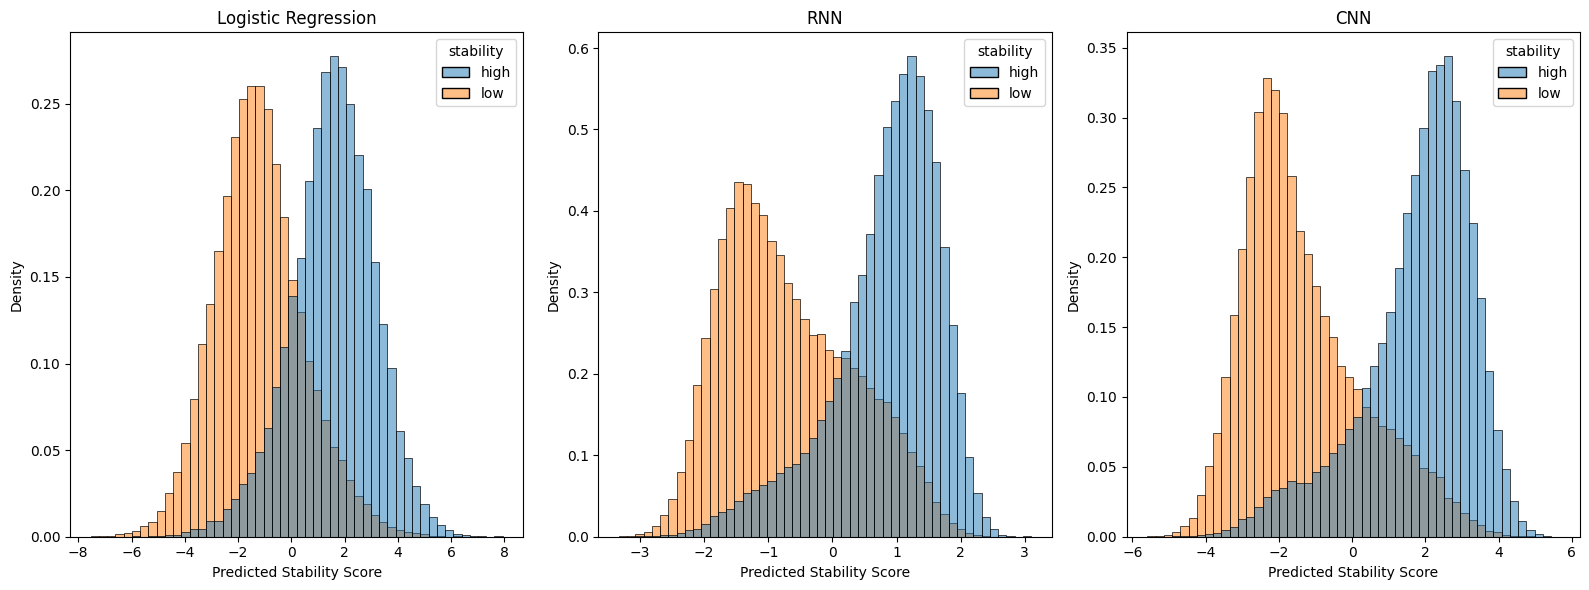

In [13]:
fig, ax = plt.subplots(1,3, figsize=(16,6))

g = sns.histplot(data=test_df_equal, x='lr_pred', hue='stability', ax=ax[0], bins=50, stat='density', common_norm=False, alpha=0.5)
ax[0].set_xlabel('Predicted Stability Score')
ax[0].set_ylabel('Density')
ax[0].set_title('Logistic Regression')


g3 = sns.histplot(data=test_df_equal, x='rnn_pred', hue='stability', ax=ax[1], bins=50, stat='density', common_norm=False, alpha=0.5)
ax[1].set_xlabel('Predicted Stability Score')
ax[1].set_ylabel('Density')
ax[1].set_title('RNN')

g2 = sns.histplot(data=test_df_equal, x='cnn_pred', hue='stability', ax=ax[2], bins=50, stat='density', common_norm=False, alpha=0.5)
ax[2].set_xlabel('Predicted Stability Score')
ax[2].set_ylabel('Density')
ax[2].set_title('CNN')

fig.tight_layout()
save_path = current_dir / 'figure_3_outputs' / 'predicted_stability_scores.pdf'
plt.savefig(save_path)

#also save the histograms as csv files
for model in ['lr', 'cnn', 'rnn']:
    #split by stability
    data = []
    #get the bin edges already sorted
    _, bin_edges = np.histogram(test_df_equal[f'{model}_pred'], bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    for stability in ['high', 'low']:
        hist, _ = np.histogram(test_df_equal[test_df_equal.stability == stability][f'{model}_pred'], bins=bin_edges, density=True)
        for center, density in zip(bin_centers, hist):
            data.append([stability, center, density])
    hist_df = pd.DataFrame(data=data, columns=['stability', 'bin_center', 'density'])
    hist_df.to_csv(current_dir / 'figure_3_outputs' / f'{model}_predicted_stability_scores_histogram.csv', index=False)

## Model Interpretability

The Logistic Regression model allows for a visualization of the coefficients, which is helpful for understanding the relative contribution of different amino acids at different positions to fitness.

In [5]:
coefficients = lrmodel.classifier.linear.weight.detach().cpu().numpy().reshape(len(AA2INDEX), -1)

In [70]:
cdr1_numbers = [28, 29, 30, 35, 36, 37, 38]
cdr1_numbers = [str(i) for i in cdr1_numbers]
cdr2_numbers = [52, 53, 54, 55, 56, 57, 58, 59, 62, 63, 64, 65, 66]
cdr2_numbers = [str(i) for i in cdr2_numbers]
cdr3_labels = ['105', '106', '107', '108', '109', '110', '111', '111A', '111B', '111C', '111D', '111E', '111F', '111G', '112H', '112G', '112F', '112E', '112D', '112C', '112B', '112A', '112', '113', '114', '115', '116', '117']

/tmp/ipykernel_1635089/2282052149.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar


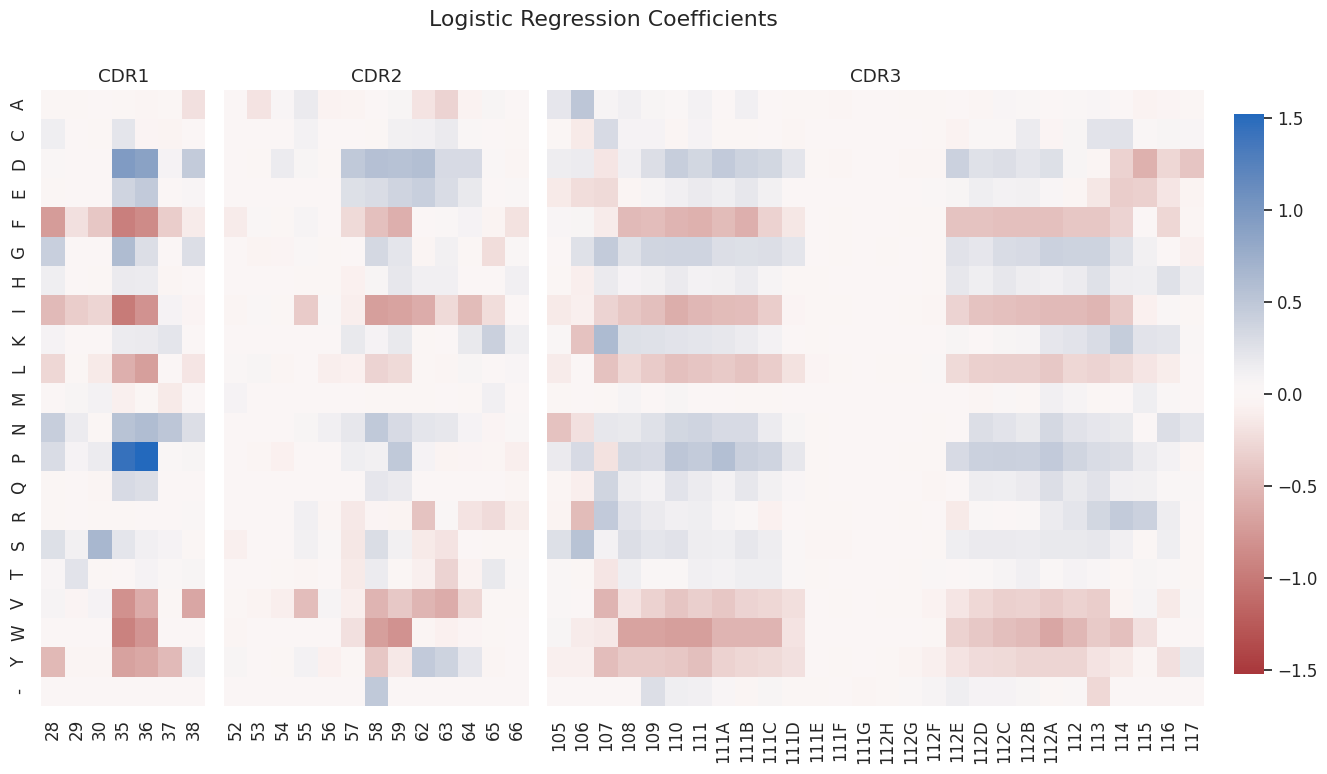

In [72]:
from matplotlib import gridspec

fig= plt.figure(figsize=(15, 8))

sns.set_theme(style = 'white', font_scale=1.1)

min_val = coefficients.min()
max_val = coefficients.max()

cdr1 = range(0,7)
cdr2 = range(7,20)
cdr3 = range(20,48)

def plot_region(ax, data_slice, title, xticklabels =[], yticklabels = [], **kwargs):
    g = sns.heatmap(data_slice, ax=ax, cbar=False, xticklabels=xticklabels, yticklabels=yticklabels, **kwargs)
    g.set_title(title)
    g.set_xlabel('')

# Create grid spec
gs = gridspec.GridSpec(1, 3, width_ratios=[len(cdr1), len(cdr2), len(cdr3)], wspace=0.05)

## other kwargs
plot_kwargs = {
    'vmin': -1 * max(abs(min_val), abs(max_val)),
    'vmax': max(abs(min_val), abs(max_val)),
    'cmap': 'vlag_r',
    'center': 0,
}

# Plot each region
ax1 = plt.subplot(gs[0])
plot_region(ax1, coefficients[:, cdr1], 'CDR1', xticklabels=cdr1_numbers, yticklabels=AA2INDEX.keys(), **plot_kwargs)

ax2 = plt.subplot(gs[1])
plot_region(ax2, coefficients[:, cdr2], 'CDR2', xticklabels=cdr2_numbers, **plot_kwargs)

ax3 = plt.subplot(gs[2])
plot_region(ax3, coefficients[:, cdr3], 'CDR3', xticklabels=cdr3_labels, **plot_kwargs)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=90)

# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax1.collections[0], cax=cbar_ax)
cbar.outline.set_visible(False)

plt.suptitle('Logistic Regression Coefficients')
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar

plt.savefig(current_dir/ 'figure_3_outputs'/ 'logistic_regression_coefficients.pdf')

In [73]:
#save the coefficients as a csv
coefficients_df = pd.DataFrame(coefficients, index=AA2INDEX.keys(), columns = cdr1_numbers + cdr2_numbers + cdr3_labels)
coefficients_df.to_csv(current_dir / 'figure_3_outputs' / 'logistic_regression_coefficients.csv')

In [74]:
train_set = pd.read_csv(data_dir / 'model_training_data/ENN_train.csv')
ds = NbStabilityDataset(train_set, AA2INDEX, cdr3_max_len=28)

In [75]:

sums = torch.zeros((len(AA2INDEX), ds.sequence_length))
for i in range(0, len(ds), 32):
    seqs, labels = ds[i:i+32]
    oh = F.one_hot(seqs, len(AA2INDEX)).transpose(1,2)
    sums += oh.sum(dim=0)
#normalize by column
sums = sums / sums.sum(dim=0)

/tmp/ipykernel_1635089/2528024278.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar


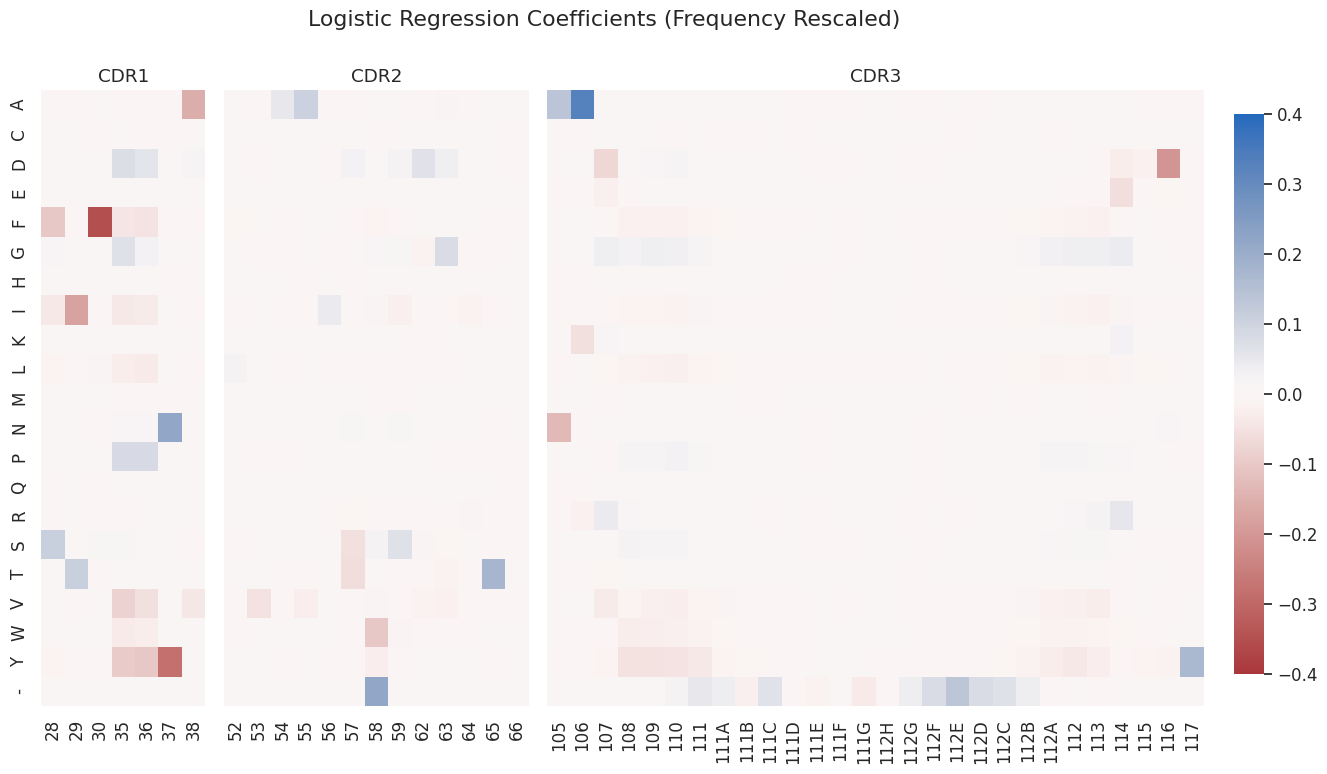

In [76]:
rescaled = coefficients * sums.numpy()
fig= plt.figure(figsize=(15, 8))

sns.set_theme(style = 'white', font_scale=1.1)

min_val = -0.4
max_val = 0.4

cdr1 = range(0,7)
cdr2 = range(7,20)
cdr3 = range(20,48)

def plot_region(ax, data_slice, title, xticklabels =[], yticklabels = [], **kwargs):
    g = sns.heatmap(data_slice, ax=ax, cbar=False, xticklabels=xticklabels, yticklabels=yticklabels, **kwargs)
    g.set_title(title)
    g.set_xlabel('')

# Create grid spec
gs = gridspec.GridSpec(1, 3, width_ratios=[len(cdr1), len(cdr2), len(cdr3)], wspace=0.05)

## other kwargs
plot_kwargs = {
    'vmin': -1 * max(abs(min_val), abs(max_val)),
    'vmax': max(abs(min_val), abs(max_val)),
    'cmap': 'vlag_r',
    'center': 0,
}

# Plot each region
ax1 = plt.subplot(gs[0])
plot_region(ax1, rescaled[:, cdr1], 'CDR1', xticklabels=cdr1_numbers, yticklabels=AA2INDEX.keys(), **plot_kwargs)

ax2 = plt.subplot(gs[1])
plot_region(ax2, rescaled[:, cdr2], 'CDR2', xticklabels=cdr2_numbers, **plot_kwargs)

ax3 = plt.subplot(gs[2])
plot_region(ax3, rescaled[:, cdr3], 'CDR3', xticklabels=cdr3_labels, **plot_kwargs)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=90)

# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax1.collections[0], cax=cbar_ax)
cbar.outline.set_visible(False)

plt.suptitle('Logistic Regression Coefficients (Frequency Rescaled)')
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar

plt.savefig(current_dir/ 'figure_3_outputs'/ 'logistic_regression_coefficients_rescaled.pdf')

In [77]:
coefficients_rescaled_df = pd.DataFrame(rescaled, index=AA2INDEX.keys(), columns = cdr1_numbers + cdr2_numbers + cdr3_labels)
coefficients_rescaled_df.to_csv(current_dir / 'figure_3_outputs' / 'logistic_regression_coefficients_frequency_scaled.csv')

## Other EDA

Let's also look at some biophysical and sequence properties that may explain some of this data

In [78]:
from scipy import stats

In [79]:
train_set = data_dir / 'model_training_data/ENN_train.csv'
train_df = pd.read_csv(train_set).groupby('stability').apply(lambda x: x.sample(100000, random_state=42)).reset_index(drop=True)

In [80]:
AROMATIC_RE = re.compile('[FYWH]')
HYDROPHOBIC_RE = re.compile('[AVMLIFCW]')
LARGE_RE = re.compile('[FYHMLWQEIRK]')
POSITIVE_RE = re.compile('[RKH]')
NEGATIVE_RE = re.compile('[DE]')

In [81]:
def analyze_cdr_patterns(df):
    # Define regex patterns
    patterns = {
        'aromatic': r'[FYWH]',
        'hydrophobic': r'[AVMLIFCW]',
        'large': r'[FYHMLWQEIRK]',
        'positive': r'[RKH]',
        'negative': r'[DE]'
    }
    
    # Function to calculate fraction of matches for a pattern
    def get_pattern_fraction(sequence, pattern):
        matches = len(re.findall(pattern, sequence))
        return matches / len(sequence)

    # Analyze CDR1 and CDR2 combined
    results_12 = []
    for _, row in df.iterrows():
        combined_seq = row['CDR1'] + row['CDR2']
        fractions = {
            'Fitness': row['stability'],
            'sequence_length': len(combined_seq)
        }
        for name, pattern in patterns.items():
            fractions[f'frac_{name}'] = get_pattern_fraction(combined_seq, pattern)
        results_12.append(fractions)
    
    # Analyze CDR3 separately
    results_3 = []
    for _, row in df.iterrows():
        fractions = {
            'Fitness': row['stability'],
            'sequence_length': len(row['CDR3'])
        }
        for name, pattern in patterns.items():
            fractions[f'frac_{name}'] = get_pattern_fraction(row['CDR3'], pattern)
        results_3.append(fractions)
    
    return pd.DataFrame(results_12), pd.DataFrame(results_3)

def perform_statistical_tests(df_12, df_3):
    feature_cols = [col for col in df_12.columns if col.startswith('frac_')]
    
    stats_results = {
        'CDR1_2': {},
        'CDR3': {}
    }
    
    # Perform t-tests for CDR1_2
    for feature in feature_cols:
        high = df_12[df_12['stability'] == 'high'][feature]
        low = df_12[df_12['stability'] == 'low'][feature]
        t_stat, p_val = stats.mannwhitneyu(high, low)
        stats_results['CDR1_2'][feature] = {
            't_statistic': t_stat,
            'p_value': p_val,
            'mean_high': high.mean(),
            'mean_low': low.mean()
        }
    
    # Perform t-tests for CDR3
    for feature in feature_cols:
        high = df_3[df_3['stability'] == 'high'][feature]
        low = df_3[df_3['stability'] == 'low'][feature]
        t_stat, p_val = stats.mannwhitneyu(high, low)
        stats_results['CDR3'][feature] = {
            't_statistic': t_stat,
            'p_value': p_val,
            'mean_high': high.mean(),
            'mean_low': low.mean()
        }
    
    return stats_results

def plot_distributions(df_12, df_3, **plotting_kwargs):
    feature_cols = [col for col in df_12.columns if col.startswith('frac_')]

    labels = ['Fraction\nAromatic',
            'Fraction\nHydrophobic', 
            'Fraction\nLarge', 
            'Fraction\nPositive', 
            'Fraction\nNegative']
    
    # Create subplots for CDR1_2 and CDR3
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))

    sns.set_theme(style='white', font_scale=1.4)
    
    # Plot CDR1_2 distributions
    data_12_melted = df_12.melt(id_vars=['Fitness'], 
                               value_vars=feature_cols,
                               var_name='Pattern',
                               value_name='Fraction')
    sns.boxplot(data=data_12_melted, x='Pattern', y='Fraction', 
                hue='Fitness', ax=axes[0], **plotting_kwargs)
    axes[0].set_title('CDR1 & CDR2 Pattern Distributions')
    axes[0].set_xticks(list(range(len(labels))), labels = labels, rotation=45)


    
    # Plot CDR3 distributions
    data_3_melted = df_3.melt(id_vars=['Fitness'], 
                             value_vars=feature_cols,
                             var_name='Pattern',
                             value_name='Fraction')
    sns.boxplot(data=data_3_melted, x='Pattern', y='Fraction', 
                hue='Fitness', ax=axes[1], **plotting_kwargs)
    axes[1].set_title('CDR3 Pattern Distributions')
    axes[1].set_xticks(list(range(len(labels))), labels = labels, rotation=45)

    
    plt.tight_layout()
    return fig

In [82]:
df_12_results, df_3_results = analyze_cdr_patterns(train_df)

In [86]:
df_12_results.to_csv(current_dir / 'figure_3_outputs' / 'cdr1_2_pattern_analysis.csv', index=False)
df_3_results.to_csv(current_dir / 'figure_3_outputs' / 'cdr3_pattern_analysis.csv', index=False)

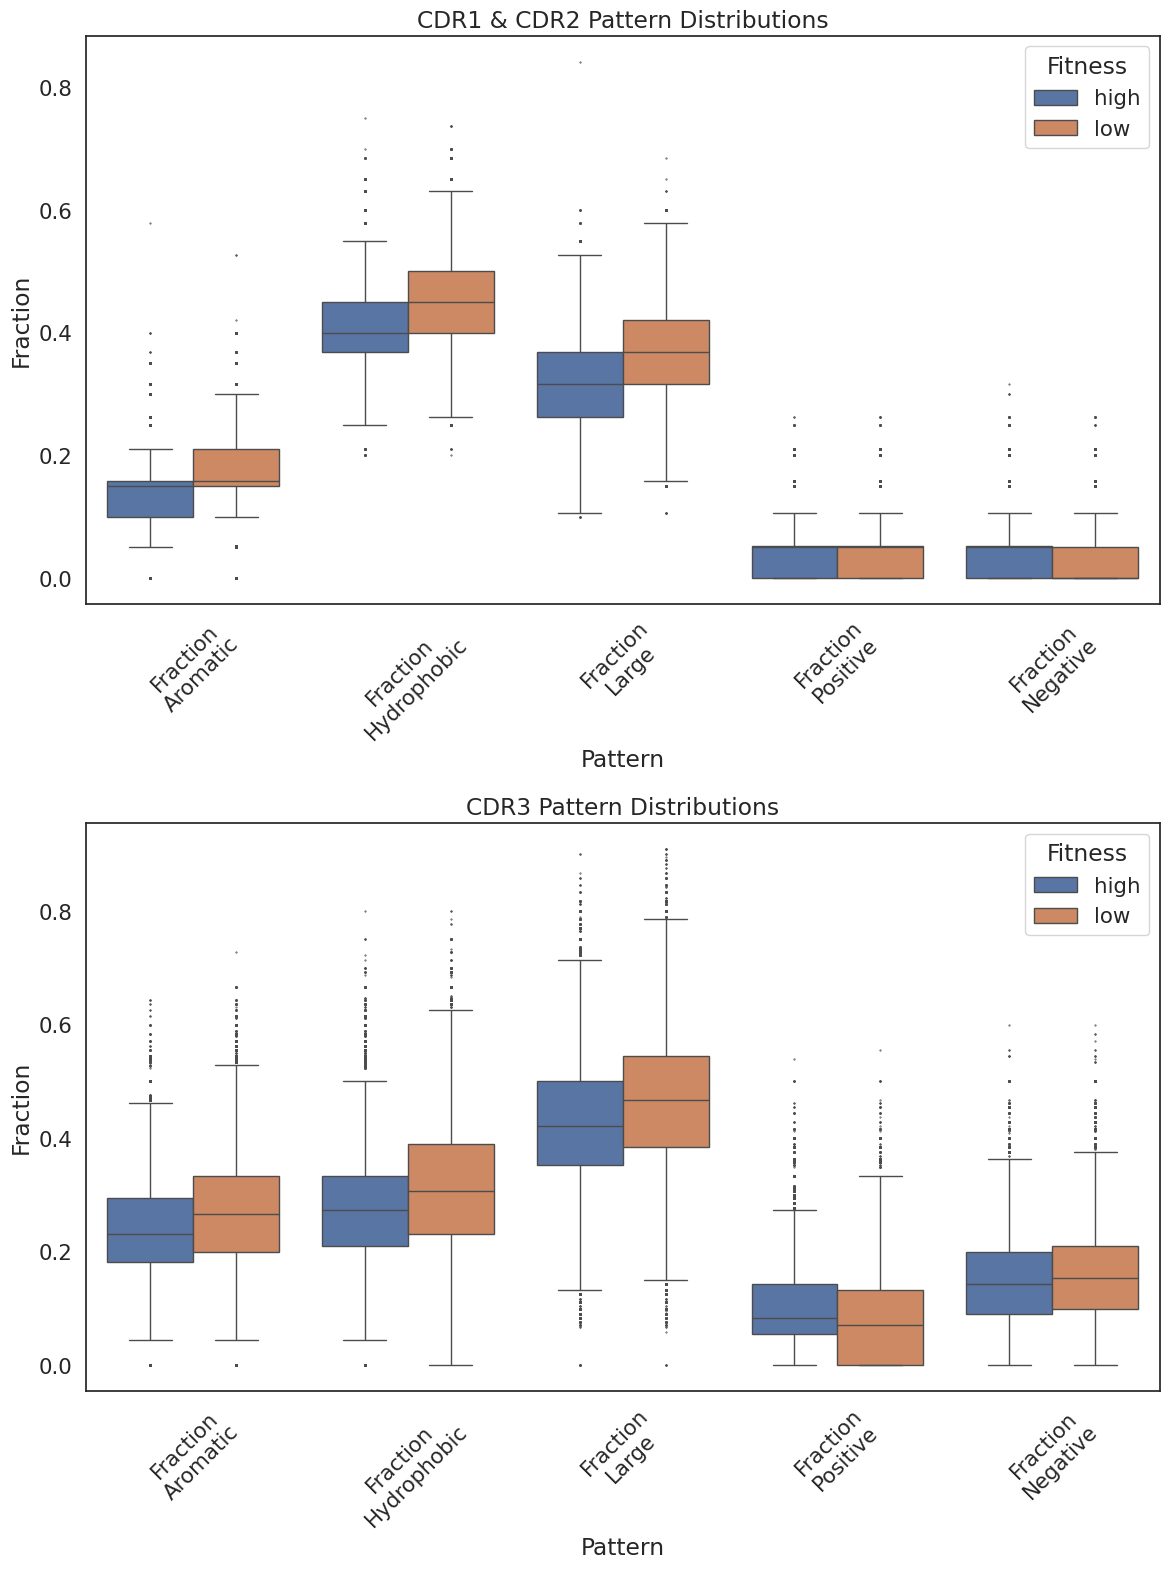

In [32]:
fig = plot_distributions(df_12_results, df_3_results, fliersize=0.5)

#save file 
fig.savefig(current_dir / 'figure_3_outputs' / 'cdr_pattern_distributions.pdf')

In [8]:
def train_random_forest(df_12, df_3, optimize_hyperparameters=True):
    """
    Train a Random Forest classifier using features from both CDR1/2 and CDR3
    with optional hyperparameter optimization
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import RandomizedSearchCV, cross_val_score
    from sklearn.preprocessing import LabelEncoder
    from scipy.stats import randint, uniform
    
    # Get feature columns (excluding 'stability' and 'sequence_length')
    feature_cols = [col for col in df_12.columns if col.startswith('frac_')]
    
    # Combine features from CDR1/2 and CDR3
    X_12 = df_12[feature_cols].values
    X_3 = df_3[feature_cols].values
    X = np.hstack([X_12, X_3])  # Combine features horizontally
    
    # Create feature names for interpretation
    feature_names = ([f'CDR12_{col}' for col in feature_cols] + 
                    [f'CDR3_{col}' for col in feature_cols])
    
    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(df_12['stability'])  # Use labels from either df, they're the same
    
    if optimize_hyperparameters:
        # Define the hyperparameter search space
        param_distributions = {
            'n_estimators': randint(50, 300),
            'max_depth': [None] + list(range(5, 31)),
            'min_samples_split': randint(2, 21),
            'min_samples_leaf': randint(1, 11),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None],
            'criterion': ['gini', 'entropy']
        }
        
        # Initialize base model for optimization
        base_rf = RandomForestClassifier(random_state=42)
        
        # Initialize RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=base_rf,
            param_distributions=param_distributions,
            n_iter=100,  # Number of parameter settings sampled
            cv=5,
            scoring='accuracy',
            n_jobs=-1,  # Use all available cores
            verbose=1,
            random_state=42
        )
        
        # Fit RandomizedSearchCV
        random_search.fit(X, y)
        
        # Get the best model
        rf = random_search.best_estimator_
        cv_scores = cross_val_score(rf, X, y, cv=5)
        
        # Store optimization results
        optimization_results = {
            'best_params': random_search.best_params_,
            'best_score': random_search.best_score_,
            'cv_results': random_search.cv_results_
        }
    else:
        # Use default Random Forest if no optimization requested
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        cv_scores = cross_val_score(rf, X, y, cv=5)
        optimization_results = None
    
    # Fit the model on all data to get feature importances
    rf.fit(X, y)
    
    # Get feature importances
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'model': rf,
        'cv_scores': cv_scores,
        'feature_importances': importances,
        'label_encoder': le,
        'optimization_results': optimization_results
    }



In [9]:
#sample 20k from high and low stability - get the indices
high_indices = train_df[train_df.stability == 'high'].sample(30000).index
low_indices = train_df[train_df.stability == 'low'].sample(30000).index

In [10]:
df_12_subset = df_12_results.loc[high_indices.union(low_indices)]
df_3_subset = df_3_results.loc[high_indices.union(low_indices)]

In [11]:
rf_results = train_random_forest(df_12_subset, df_3_subset, optimize_hyperparameters=True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [12]:
rf_results

{'model': RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                        max_depth=13, max_features='log2', min_samples_leaf=3,
                        n_estimators=297, random_state=42),
 'cv_scores': array([0.74525   , 0.748     , 0.74541667, 0.744     , 0.7465    ]),
 'feature_importances':                   feature  importance
 1  CDR12_frac_hydrophobic    0.156275
 2        CDR12_frac_large    0.151149
 0     CDR12_frac_aromatic    0.120924
 6   CDR3_frac_hydrophobic    0.112501
 7         CDR3_frac_large    0.111212
 5      CDR3_frac_aromatic    0.103150
 9      CDR3_frac_negative    0.078132
 8      CDR3_frac_positive    0.076013
 4     CDR12_frac_negative    0.061653
 3     CDR12_frac_positive    0.028990,
 'label_encoder': LabelEncoder(),
 'optimization_results': {'best_params': {'bootstrap': True,
   'class_weight': 'balanced_subsample',
   'criterion': 'entropy',
   'max_depth': 13,
   'max_features': 'log2',
   'min_samples_leaf': 3,


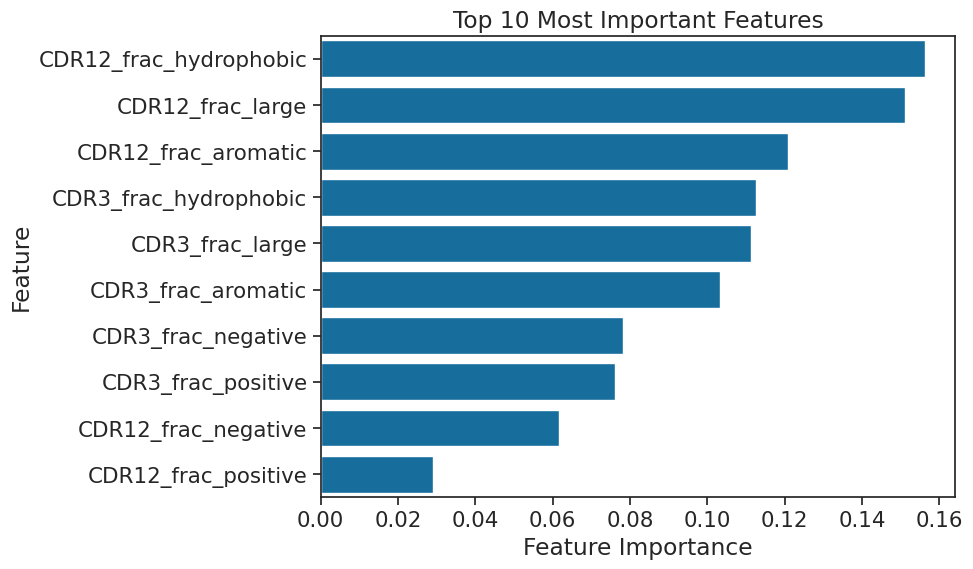

In [20]:
def plot_feature_importances(importances):
    """
    Plot feature importances from the Random Forest
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances.head(10), x='importance', y='feature')
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    return plt.gcf()

fig = plot_feature_importances(rf_results['feature_importances'])

In [13]:
#add cdr1/2 and cdr3 to the results dataframes 
df_12_results.rename(columns={col: f'CDR1/2_{col}' for col in df_12_results.columns if col.startswith('frac_')}, inplace=True)
df_3_results.rename(columns={col: f'CDR3_{col}' for col in df_3_results.columns if col.startswith('frac_')}, inplace=True)

In [14]:
df_12_results.rename(columns={'sequence_length': 'CDR1/2_sequence_length'}, inplace=True)
df_3_results.rename(columns={'sequence_length': 'CDR3_sequence_length'}, inplace=True)

In [15]:
combined_results = pd.concat([df_12_results, df_3_results], axis=1)

In [16]:
#remove one of the stability columns
combined_drop = combined_results.drop(columns='stability')

In [17]:
combined_drop['stability'] = train_df['stability']

/tmp/ipykernel_115980/1076662870.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_115980/1076662870.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


[Text(0, 0, 'CDR3_frac_aromatic'),
 Text(1, 0, 'CDR3_frac_hydrophobic'),
 Text(2, 0, 'CDR3_frac_large'),
 Text(3, 0, 'CDR3_frac_positive'),
 Text(4, 0, 'CDR3_frac_negative')]

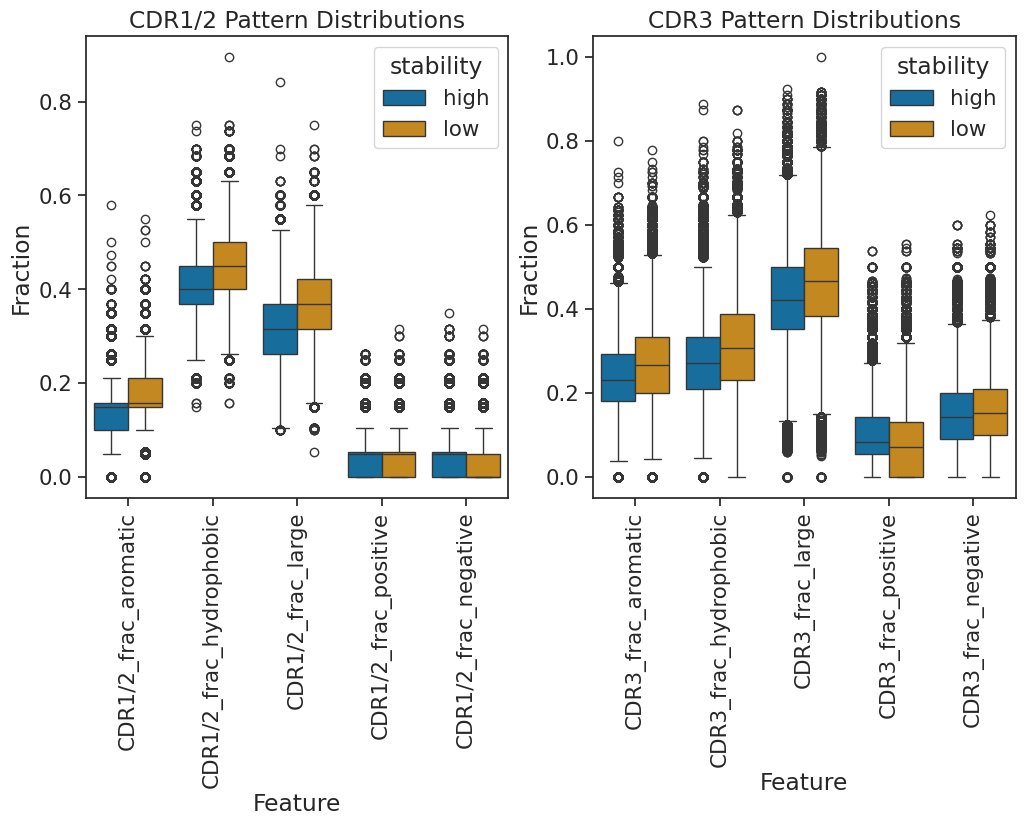

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.set_theme(style='white', palette='colorblind', font_scale=1.4)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.minor.left'] = True

#melt
melted = combined_drop[list(filter(lambda x: 'frac' in x, df_12_results.columns)) + ['stability']].melt(id_vars='stability', var_name='Feature', value_name='Fraction')
sns.boxplot(data=melted, x='Feature', y='Fraction', hue='stability', ax=axs[0])
axs[0].set_title('CDR1/2 Pattern Distributions')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

melted = combined_drop[list(filter(lambda x: 'frac' in x, df_3_results.columns)) + ['stability']].melt(id_vars='stability', var_name='Feature', value_name='Fraction')
sns.boxplot(data=melted, x='Feature', y='Fraction', hue='stability', ax=axs[1])
axs[1].set_title('CDR3 Pattern Distributions')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)


In [23]:
combined_drop.to_csv(current_dir / 'figure_3_outputs' / 'cdr_pattern_results.csv')